# 计算瓦片中的细胞核数量

在这个笔记本中，我们将处理以zarr格式保存的大型数据集，以计算单个瓦片中的细胞数量。对于每个瓦片，我们将在输出图像中写入一个像素。因此，我们生成的细胞计数图像比原始图像小，缩小的因子对应于瓦片大小。

In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from numcodecs import Blosc

出于演示目的，我们使用由德累斯顿工业大学卡尔·古斯塔夫·卡鲁斯大学医院OncoRay的Theresa Suckert提供的数据集。该数据集的许可为[License: CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)。我们在这里使用了一个裁剪版本，该版本被重新保存为8位图像，以便能够随笔记本一起提供。您可以在[在线](https://zenodo.org/record/4276076#.YX1F-55BxaQ)找到完整大小的16位CZI格式图像。

In [2]:
image = imread('../../data/P1_H_C3H_M004_17-cropped.tif')[1]

# for testing purposes, we crop the image even more.
# comment out the following line to run on the whole 5000x2000 pixels
image = image[1000:1500, 1000:1500]

#compress AND change the numpy array into a zarr array
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

# Convert image into zarr array
chunk_size = (100, 100)
zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

# save zarr to disk
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

## 加载基于zarr的图像
Dask内置了对zarr文件格式的支持。我们可以直接从zarr文件创建dask数组。

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(500, 500), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

我们可以直接对这个分块数据集应用图像处理。

## 计数细胞核
为了计数细胞核，我们设置了一个简单的图像处理工作流程，对数据集应用Voronoi-Otsu标记。之后，我们计数分割的对象。由于接触瓦片边界的细胞核可能被重复计数，我们必须对每个瓦片的计数进行修正。从技术上讲，我们可以移除接触垂直或水平瓦片边界的对象。然而，有一种更简单的方法来纠正这个错误：我们在分割后计数细胞核的数量。然后，我们移除所有接触任何图像边界的细胞核，再次计数剩余的细胞核。然后我们可以假设被移除的细胞核中应该计数一半。因此，我们将这两次计数（移除边缘前后）相加，并计算这两次测量的平均值。特别是在包含许多细胞核的大型瓦片上，剩余的误差应该可以忽略不计。不建议在每个瓦片仅包含少量细胞核时应用这种估算细胞计数方法。

In [4]:
def count_nuclei(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    print("Processing image of size", image.shape)
    
    # Count nuclei including those which touch the image border
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    label_intensity_map = cle.mean_intensity_map(image, labels)
    
    high_intensity_labels = cle.exclude_labels_with_map_values_within_range(label_intensity_map, labels, maximum_value_range=20)
    nuclei_count = high_intensity_labels.max()
    
    # Count nuclei including those which touch the image border
    labels_without_borders = cle.exclude_labels_on_edges(high_intensity_labels)
    nuclei_count_excluding_borders = labels_without_borders.max()
    
    # Both nuclei-count including and excluding nuclei at image borders 
    # are no good approximation. We should exclude the nuclei only on 
    # half of the borders to get a good estimate.
    # Alternatively, we just take the average of both counts.
    result = np.asarray([[(nuclei_count + nuclei_count_excluding_borders) / 2]])
    
    print(result.shape)
    
    return result

在开始计算之前，我们需要停用pyclesperanto中操作的异步执行。[另请参阅相关问题](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163)。

In [5]:
cle.set_wait_for_kernel_finish(True)

这次我们不使用瓦片重叠，因为我们不测量细胞核的属性，因此不需要对它们进行完美的分割。

In [6]:
tile_map = da.map_blocks(count_nuclei, zarr_image)

tile_map

Processing image of size (0, 0)
Processing image of size (1, 1)
(1, 1)
Processing image of size (0, 0)


dask.array<count_nuclei, shape=(500, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

由于结果图像比原始图像小得多，我们可以计算整个结果图。

In [7]:
result = tile_map.compute()

Processing image of size (100, 100)
Processing image of sizeProcessing image of size (100, 100)
Processing image of size (100, 100)
 (100, 100)
Processing image of size (100, 100)
Processing image of size (100, 100)
Processing image of sizeProcessing image of size (100, 100)
 Processing image of size(100, 100)
 (100, 100)
Processing image of size (100, 100)
(1, 1)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)(1, 1)

Processing image of size (100, 100)
Processing image of size(1, 1)
 (100, 100)
Processing image of size (100, 100)
(1, 1)
(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
(1, 1)
Processing image of sizeProcessing image of size  (100, 100)
(100, 100)
(1, 1)(1, 1)

(1, 1)
Processing image of size Processing image of size(100, 100) 

In [8]:
result.shape

(5, 5)

同样，由于结果图很小，我们可以直接可视化它。

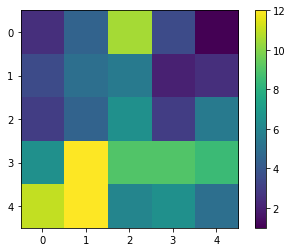

In [9]:
cle.imshow(result, colorbar=True)

通过对原始图像的快速目视检查，我们可以看到确实在图像的左下角有比右上角更多的细胞。

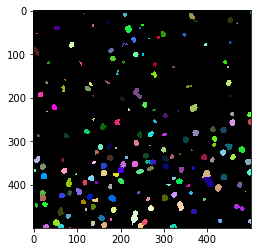

In [10]:
cle.imshow(cle.voronoi_otsu_labeling(image, spot_sigma=3.5), labels=True)